In [29]:
import pandas as pd
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt

In [30]:
SAVE_DATA = True
OR_COUNT = 52
TOTAL_SURGEONS = 100 # Assume there are 100 surgeons
TOTAL_SERVICES = 5
WEEKDAY_BED_COUNTS = [311, 328, 336, 332, 322, 289, 278] # This is data from origin paper

In [31]:
# Define values for each column
ORs = range(1, OR_COUNT+1)  # 52 rooms (1 to 52)
weekdays = range(1, 8)  # 1 to 7 (Monday to Sunday)
week_numbers = range(1, 5)  # 1 to 4 (Week in a month)

# Create all possible combinations
data = list(itertools.product(ORs, weekdays, week_numbers))

# Convert to DataFrame
df = pd.DataFrame(data, columns=["ORs", "Weekday", "Week Number"])
m = df.shape[0]

df

,ORs,Weekday,Week Number
0,1,1,1
1,1,1,2
2,1,1,3
3,1,1,4
4,1,2,1
...,...,...,...
1451,52,6,4
1452,52,7,1
1453,52,7,2
1454,52,7,3


In [32]:
# add Block into dataset according to weekdays and ORs

block = np.zeros(m, dtype='object')

for i in range(m):
    day = df['Weekday'][i]
    room = df['ORs'][i]

    block[i] = f"(d{day},o{room})"
    
df['Block'] = block

In [33]:
def countForORs(total_count, OR_count=OR_COUNT):
    """
    Every Block gets (total_bed / OR_count + r) beds for each day
    Where r is randomely assigned to complete the gap caused by process of convert float to int
    """
    total_count = total_count + random.randint(-3,3)
    count_for_each_rooms = np.full(OR_count,np.floor(total_count / OR_count).astype(int))

    while count_for_each_rooms.sum() < total_count: # if gap exist
        gap = total_count - count_for_each_rooms.sum()
        gap = min(10, gap) # colculate the gap, but add 10 at most

        arr = np.array([1] * gap + [0] * (OR_count - gap))
        # Shuffle the array randomly
        np.random.shuffle(arr)

        count_for_each_rooms += arr # randomely add one bed to some ORs

    return count_for_each_rooms

# countForORs(311)

In [34]:
# Add beds count for each operating room.
beds = np.zeros(m, dtype='int')
for week_ in range(1, 5):
    for day_ in range(1, 8):
        count_for_each_rooms = countForORs(WEEKDAY_BED_COUNTS[day_-1])
        for OR_ in range(1, OR_COUNT+1):
            idx = df[(df['Weekday'] == day_) & (df['Week Number'] == week_) & (df['ORs'] == OR_)].index[0]
            beds[idx] = count_for_each_rooms[OR_-1]

df['Beds'] = beds

df

,ORs,Weekday,Week Number,Block,Beds
0,1,1,1,"(d1,o1)",5
1,1,1,2,"(d1,o1)",6
2,1,1,3,"(d1,o1)",6
3,1,1,4,"(d1,o1)",7
4,1,2,1,"(d2,o1)",7
...,...,...,...,...,...
1451,52,6,4,"(d6,o52)",7
1452,52,7,1,"(d7,o52)",5
1453,52,7,2,"(d7,o52)",5
1454,52,7,3,"(d7,o52)",5


In [35]:
# Assign surgeons to each OR for each day
surgeon_ids = list(range(TOTAL_SURGEONS))
# surgeon_ids

In [37]:
surgeon = np.zeros(m, dtype='int')
service = np.zeros(m, dtype='int')
for week_ in range(1, 5):
    for day_ in range(1, 8):
        sub_df_index = list(df[(df['Weekday'] == day_) & (df['Week Number'] == week_)].index)
        selected_surgeon = random.sample(surgeon_ids, OR_COUNT)
        for i in range(OR_COUNT):
            surgeon[sub_df_index[i]] = selected_surgeon[i]
            service[sub_df_index[i]] = selected_surgeon[i] // 20

df['Surgeon ID'] = surgeon
df['Service ID'] = service

df

,ORs,Weekday,Week Number,Block,Beds,Surgeon ID,Service ID
0,1,1,1,"(d1,o1)",5,13,0
1,1,1,2,"(d1,o1)",6,42,2
2,1,1,3,"(d1,o1)",6,98,4
3,1,1,4,"(d1,o1)",7,12,0
4,1,2,1,"(d2,o1)",7,46,2
...,...,...,...,...,...,...,...
1451,52,6,4,"(d6,o52)",7,40,2
1452,52,7,1,"(d7,o52)",5,26,1
1453,52,7,2,"(d7,o52)",5,57,2
1454,52,7,3,"(d7,o52)",5,62,3


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ORs          1456 non-null   int64 
 1   Weekday      1456 non-null   int64 
 2   Week Number  1456 non-null   int64 
 3   Block        1456 non-null   object
 4   Beds         1456 non-null   int64 
 5   Surgeon ID   1456 non-null   int64 
 6   Service ID   1456 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 79.8+ KB


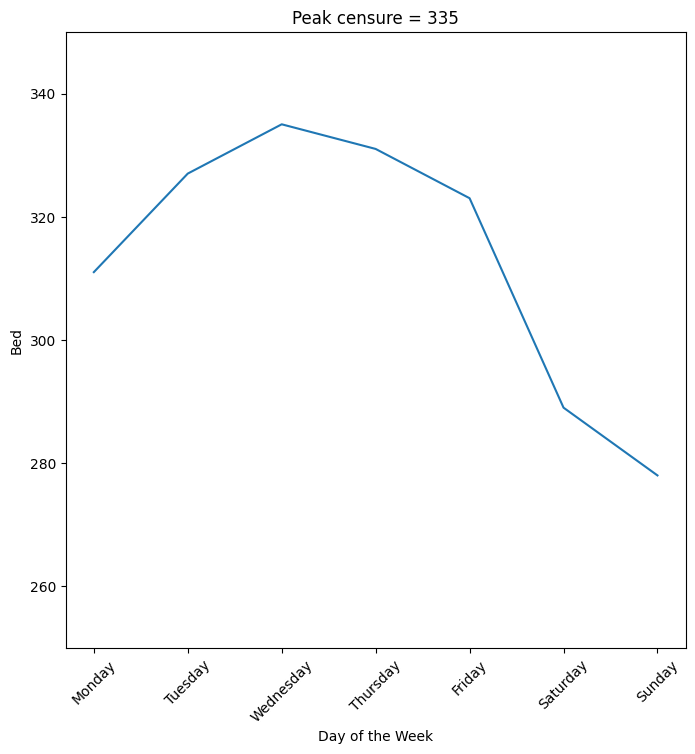

In [39]:
total_weekday_daycount = [0] * 7

for i in range(1,5):
    weekn = df['Week Number'] == i
    df_weekn = df[weekn]
    
    weekday_daycount = []
    for d in range(1, 8):
        day_count = df_weekn[df_weekn['Weekday'] == d]['Beds'].sum()
        weekday_daycount.append(day_count)
    total_weekday_daycount = [total_weekday_daycount[j] + weekday_daycount[j] for j in range(7)]

avg_weekday_daycount = [int(count / 4) for count in total_weekday_daycount]



# Define labels for better readability
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Count occurrences of each day
day_counts = avg_weekday_daycount

# Plot using Matplotlib
plt.figure(figsize=(8, 8))
plt.plot(range(7), day_counts)

# Set labels
plt.xticks(ticks=range(7), labels=day_labels, rotation=45)
plt.xlabel("Day of the Week")
plt.ylabel("Bed")
plt.ylim(250, 350)
plt.title(f"Peak censure = {max(avg_weekday_daycount)}")

# Show plot
plt.show()

In [40]:
# Save dataset
if SAVE_DATA: # Dataset generation process contains some randomness, so this cell should not run to avoid inconsistency
    df.to_csv("dataset.csv", index=False)
    print('dataset saved')

dataset saved
